### libraries

In [408]:
import numpy as np 
import pandas as pd
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [472]:
def GenerateFis(df):
    def split(data):
        return [data[-7:], data[-14:-7], data[-21:-14], data[-28:-21], data[-34:-29]]

    def holiday(df):
        condition_holiday = (
        (df.DATE.dt.month == 1) & ((df.DATE.dt.day >= 1) & (df.DATE.dt.day <= 8)) # winter
        | (df.DATE.dt.month == 2) & ((df.DATE.dt.day >= 21) & (df.DATE.dt.day <= 25)) # around 23 feb
        | (df.DATE.dt.month == 3) & ((df.DATE.dt.day >= 6) & (df.DATE.dt.day <= 10)) # around 8 mar
        | (df.DATE.dt.month == 5) & ((df.DATE.dt.day >= 1) & (df.DATE.dt.day <= 10)) # may
        | (df.DATE.dt.month == 6) & ((df.DATE.dt.day >= 10) & (df.DATE.dt.day <= 14)) # around 12 june
        | (df.DATE.dt.month == 11) & ((df.DATE.dt.day >= 2) & (df.DATE.dt.day <= 6)) # around 4 nov
        )
        return condition_holiday + 0
    
    def shift(df, i):
        for n in [1,2,3,4,5]:
            N = n + i - 1
            df['same_day_{}_week_ago'.format(n+5)] = df.groupby(['ATM_ID'])['CLIENT_OUT'].shift(7*N)
            df['mean_{}_week_ago'.format(n+5)] = df.groupby(['ATM_ID'])['mean'].shift(7*N)
            df['std_{}_week_ago'.format(n+5)] = df.groupby(['ATM_ID'])['std'].shift(7*N)
            df['same_day_{}_week_ago_plusday'.format(n+5)] = df.groupby(['ATM_ID'])['CLIENT_OUT'].shift(7*N-1)
            df['same_day_{}_week_ago_minusday'.format(n+5)] = df.groupby(['ATM_ID'])['CLIENT_OUT'].shift(7*N+1)
        return df
    
    df['month_of_year'] = df.DATE.dt.month
    df['day_of_week'] = df.DATE.dt.dayofweek
    df['day_of_month'] = df.DATE.dt.day
    df['week_of_month'] = (df.DATE.dt.day  - 1) // 7 + 1
    df['holiday_dummy'] = holiday(df)
    
    list_dummies = ['day_of_week', 
                'day_of_month',
                'week_of_month',
                'month_of_year']
    df = pd.get_dummies(df, columns=list_dummies)
    
    df['mean'] = df.CLIENT_OUT.rolling(window=7, center=False).mean()
    df['std'] = df.CLIENT_OUT.rolling(window=7, center=False).std()
    dfs = []
    for i in range(1, 6):
        dfs.append(shift(df, i))
    
    for i in range(len(dfs)):
        dfs[i] = dfs[i].drop('mean', 1)
        dfs[i] = dfs[i].drop('std', 1)
    
    return dfs

In [473]:
data = pd.read_csv('train.csv.zip', parse_dates=['DATE'])

In [ ]:
data

In [474]:
a = GenerateFis(data)

In [475]:
for i in a:
    print(i.shape)

(287400, 84)
(287400, 84)
(287400, 84)
(287400, 84)
(287400, 84)


In [476]:
a[0]

,DATE,ATM_ID,CLIENT_OUT,holiday_dummy,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,same_day_9_week_ago,mean_9_week_ago,std_9_week_ago,same_day_9_week_ago_plusday,same_day_9_week_ago_minusday,same_day_10_week_ago,mean_10_week_ago,std_10_week_ago,same_day_10_week_ago_plusday,same_day_10_week_ago_minusday
0,2015-01-01,0,91600,1,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,0,136500,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,0,335400,1,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,0,379000,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,0,344100,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-01-06,0,575300,1,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-01-07,0,158200,1,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2015-01-08,0,296500,1,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2015-01-09,0,453400,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2015-01-10,0,415900,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [464]:
atm00 = a[0][a[0].ATM_ID==0]
atm04 = a[4][a[4].ATM_ID==0]

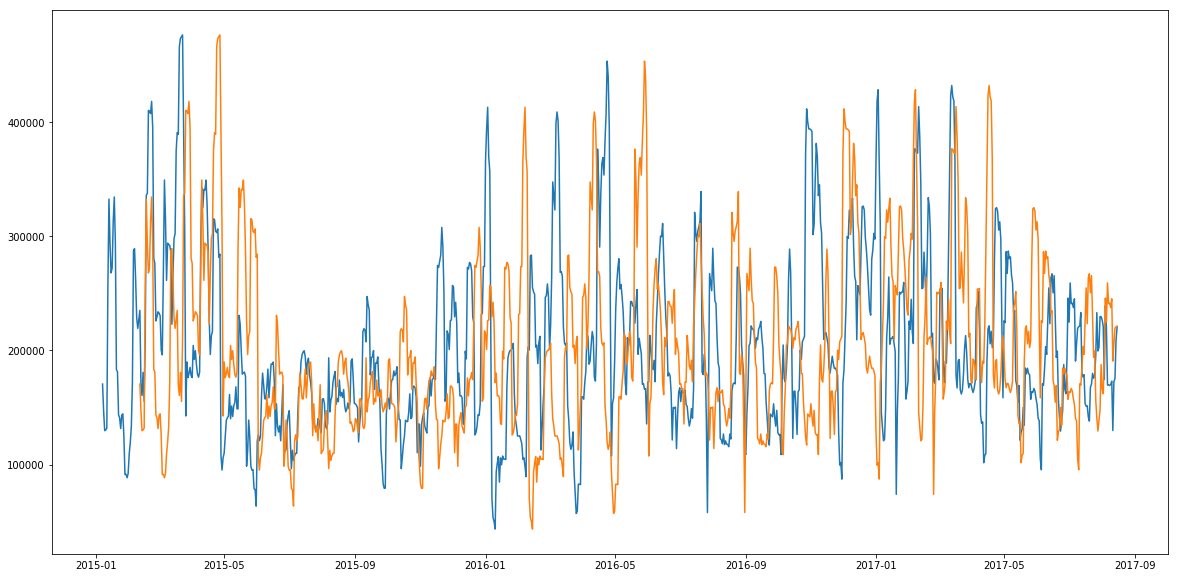

In [438]:
plt.figure(figsize=(20,10))
#plt.plot(atm0.DATE, atm0.CLIENT_OUT)
plt.plot(atm04.DATE, atm04['std'])
plt.plot(atm04.DATE, atm04['std_6_week_ago'])

In [465]:
atm00['mean_1month'] = atm00.CLIENT_OUT.rolling(window=30, center=False).mean()

/home/progiv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [466]:
atm00['mean_2months_shifted'] = atm00.CLIENT_OUT.rolling(window=60).mean().shift(30)

/home/progiv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [469]:
atm00['mean_delta'] = atm00['mean_1month'] - atm00['mean_2months_shifted']

/home/progiv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


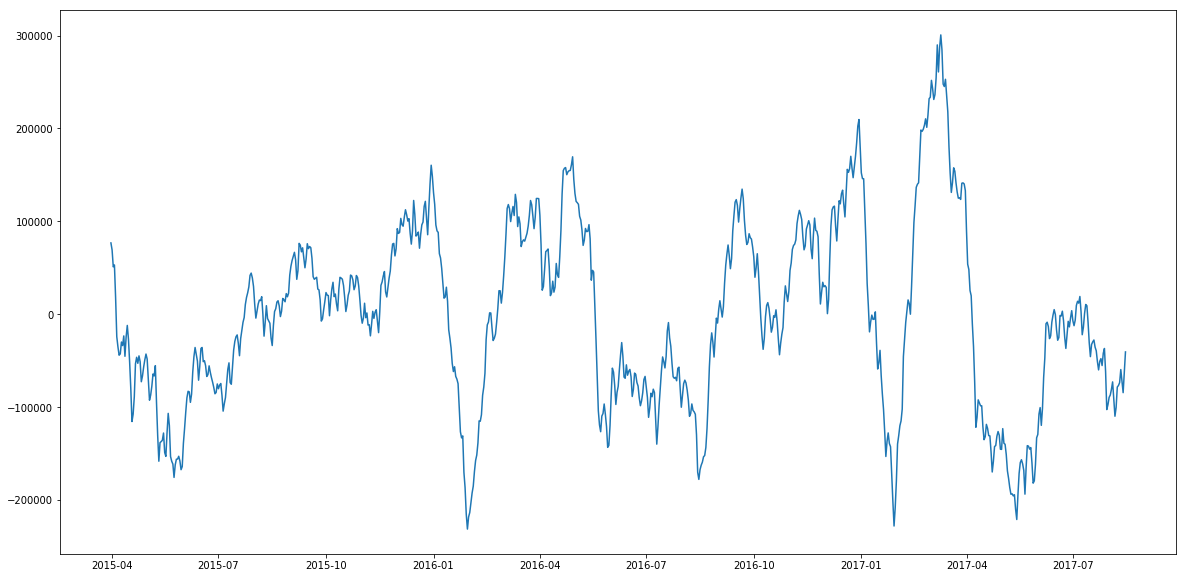

In [471]:
plt.figure(figsize=(20,10))
#plt.plot(atm0.DATE, atm0.CLIENT_OUT)
plt.plot(atm00.DATE, atm00['mean_delta'])

### read data

In [346]:
train = pd.read_csv('train.csv.zip', parse_dates=['DATE'])
train.head()

,DATE,ATM_ID,CLIENT_OUT
0,2015-01-01,0,91600
1,2015-01-02,0,136500
2,2015-01-03,0,335400
3,2015-01-04,0,379000
4,2015-01-05,0,344100


In [350]:
train.groupby('ATM_ID')

In [188]:
df = train

df['month_of_year'] = df.DATE.dt.month

### generate features

In [189]:
def DivideByMean(df):
    means = df.groupby(['ATM_ID', 'month_of_year'], as_index=False)['CLIENT_OUT'].mean()
    mean_df = pd.DataFrame(means)
    mean_df.rename(columns={'CLIENT_OUT': 'mean'}, inplace=True)
    
    merged_df = pd.merge(df[['DATE', 'ATM_ID', 'month_of_year']], mean_df, on=['ATM_ID', 'month_of_year'], how='outer')
    df.CLIENT_OUT = df.CLIENT_OUT / merged_df['mean']
    
    last_date = merged_df.DATE.max()
    means_of_last_month_df = merged_df[merged_df.DATE == last_date]
    return df, means_of_last_month_df


def MultiplyByMean(y_predicted, means_of_last_month_df):
    y_predicted.CLIENT_OUT = y_predicted.CLIENT_OUT * pd.merge(y_predicted, means_of_last_month_df, 
                                                    on='ATM_ID', how='outer')['mean']
    
    return y_predicted

In [190]:
pd.merge(df, means_of_last_month_df, on='ATM_ID', how='outer')

,DATE_x,ATM_ID,CLIENT_OUT,month_of_year_x,DATE_y,month_of_year_y,mean
0,2015-01-01,0,91600,1,2017-08-15,8,381470.129870
1,2015-01-02,0,136500,1,2017-08-15,8,381470.129870
2,2015-01-03,0,335400,1,2017-08-15,8,381470.129870
3,2015-01-04,0,379000,1,2017-08-15,8,381470.129870
4,2015-01-05,0,344100,1,2017-08-15,8,381470.129870
5,2015-01-06,0,575300,1,2017-08-15,8,381470.129870
6,2015-01-07,0,158200,1,2017-08-15,8,381470.129870
7,2015-01-08,0,296500,1,2017-08-15,8,381470.129870
8,2015-01-09,0,453400,1,2017-08-15,8,381470.129870
9,2015-01-10,0,415900,1,2017-08-15,8,381470.129870


In [191]:
df = train

## We add features to df

df['day_of_week'] = df.DATE.dt.dayofweek
df['day_of_month'] = df.DATE.dt.day
df['week_of_month'] = (df.DATE.dt.day  - 1) // 7 + 1
df['month_of_year'] = df.DATE.dt.month
   
condition_holiday = (
    (df.DATE.dt.month == 1) & ((df.DATE.dt.day >= 1) & (df.DATE.dt.day <= 8)) # winter
    | (df.DATE.dt.month == 2) & ((df.DATE.dt.day >= 21) & (df.DATE.dt.day <= 25)) # around 23 feb
    | (df.DATE.dt.month == 3) & ((df.DATE.dt.day >= 6) & (df.DATE.dt.day <= 10)) # around 8 mar
    | (df.DATE.dt.month == 5) & ((df.DATE.dt.day >= 1) & (df.DATE.dt.day <= 10)) # may
    | (df.DATE.dt.month == 6) & ((df.DATE.dt.day >= 10) & (df.DATE.dt.day <= 14)) # around 12 june
    | (df.DATE.dt.month == 11) & ((df.DATE.dt.day >= 2) & (df.DATE.dt.day <= 6)) # around 4 nov
)   
df['holiday_dummy'] = condition_holiday + 0

# divide by mean
df, means_of_last_month_df = DivideByMean(df)

# convert to dummies
list_dummies = ['day_of_week', 
                'day_of_month',
                'week_of_month',
                'month_of_year']
df = pd.get_dummies(df, columns=list_dummies)


In [97]:
df #new

,DATE,ATM_ID,CLIENT_OUT,holiday_dummy,rolling_mean_7_days,rolling_mean_30_days,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,...,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12
0,2015-01-01,0,0.281083,1,NaN,NaN,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2015-01-02,0,0.418862,1,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015-01-03,0,1.029204,1,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2015-01-04,0,1.162995,1,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015-01-05,0,1.055901,1,NaN,NaN,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2015-01-06,0,1.765359,1,NaN,NaN,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2015-01-07,0,0.485451,1,0.885551,NaN,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,2015-01-08,0,0.909836,1,0.975373,NaN,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,2015-01-09,0,1.391298,0,1.114292,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2015-01-10,0,1.276226,0,1.149581,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
# # multiply back by mean
MultiplyByMean(df[['ATM_ID', 'CLIENT_OUT']], means_of_last_month_df)


/home/progiv/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,ATM_ID,CLIENT_OUT
0,0,1.072246e+05
1,0,1.597834e+05
2,0,3.926107e+05
3,0,4.436478e+05
4,0,4.027947e+05
5,0,6.734316e+05
6,0,1.851849e+05
7,0,3.470754e+05
8,0,5.307385e+05
9,0,4.868420e+05


In [95]:
df #old

,DATE,ATM_ID,CLIENT_OUT,month_of_year
0,2015-01-01,0,91600,1
1,2015-01-02,0,136500,1
2,2015-01-03,0,335400,1
3,2015-01-04,0,379000,1
4,2015-01-05,0,344100,1
5,2015-01-06,0,575300,1
6,2015-01-07,0,158200,1
7,2015-01-08,0,296500,1
8,2015-01-09,0,453400,1
9,2015-01-10,0,415900,1


In the end:

In [5]:
# # multiply back by std
# df = MultiplyBySTD(df, stds)

In [137]:
# how to work with datetime
# from datetime import datetime, timedelta
# dftry = df.copy()
# for N in [1,2,3,4,5]:
#     dftry['date_{}_days_ago'.format(N)] = dftry.DATE - timedelta(days=7*N)

In [207]:
for N in [1,2,3,4,5]:
    df['out_{}_weeks_ago'.format(N)] = df.CLIENT_OUT.shift(7*N)
    df['out_{}_weeks_ago_plus_day'.format(N)] = df.CLIENT_OUT.shift(7*N-1)
    df['out_{}_weeks_ago_minus_day'.format(N)] = df.CLIENT_OUT.shift(7*N+1)